In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
import math
from functools import total_ordering
from numpy.random import default_rng

#our class!
from LJParticles import LJParticles

# Final Project: Molecular Dynamics With the Lennard-Jones Potential

By Conor Floyd and Nikolas Hall

## Background
### How Do Neutral Molecules Interact?

Key Ideas:
- All atoms and molecules, even those with no net charge, experience attractive and repulsive forces
- In polar molecules, forces arise from permanent dipoles due to uneven electron sharing
- In nonpolar molecules and inert atoms (such as the noble gases), random electron motion creates temporary dipoles
- These dipoles are short-lived, but they can still induce dipoles in neighboring atoms/molecules
- Dipole-dipole interactions can generate weak attractive forces

These forces, known as **London dispersion forces**, grow stronger as the inter-particle distance decreases. If two particles get too close, their electron orbitals begin to overlap, producing strong repulsive forces. Between the two extremes lies a point where the net force on each particle is zero. This is the equilibrium separation.

<img src="London.png" style="width:600px"/>

### Our Goals for This Project

We had two main goals for this project: 
1. Simulate a system of particles interacting through London dispersion forces
2. "Cool" the system to observe a change of phase

To do simulate London dispersion forces, we implemented the Lennard-Jones potential. To lower the temperature of our system, we periodically reduced the particles' kinetic energies.

### What is the Lennard-Jones Potential?

The **Lennard-Jones** potential energy function describes the weak long-range attractions and strong short-range repulsions typical of a system of particles interacting via London dispersion forces. The function is as follows:
$$
    V(r) = 4 \times \epsilon \times [(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6}]
$$
$r$ = Distance between the centers of two particles

$V(r)$ = Potential energy of interaction between the two particles

$\epsilon$ = Depth of the potential well (units of energy)

$\sigma$ = "Van der Waals" radius, the distance at which $V(r) = 0$ (units of length)

The strength of associated Lennard-Jones force is given by:

$$
    F(r) = -\frac{\partial V}{\partial r} = 24 \times \frac{\epsilon}{r} \times [2 \times (\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6}]
$$

The $(\frac{\sigma}{r})^{12}$ term dominates at small $r$ and captures the short-range repulsive forces. The $(\frac{\sigma}{r})^{6}$ describes the weak attractive force that dominates at larger $r$. At the bottom of the Lennard-Jones potential well, the force on each particle is zero.

<img src="LJ-Plot.png" style="width:600px"/>

## Major Decisions
### Boundary Conditions

Two options we explored: **Periodic** and **Hard Wall**

**Periodic:** Particles "wrap around" the edges, like Pac-Man.

Pros:
- Avoid wall hits (which we'll see are problematic)
- Avoid strange behavior near walls

Cons:
- Difficult to implement
    - Distance between particles (calculated O(n^2) times each dt) nontrivial, slower
- Unphysical oscillations
    - If using only nearest particle, system may tend towards unphysical oscilations, some of which increase total energy

<img src="oldBCproblem.gif" style="width:600px"/>

**Hard Wall:** Particles bounce off of walls

Pros:
- Simple

Cons:
- Wall hits pose a threat to energy conservation

### Energy Conservation During Wall Hits

There are a few different ways to implement wall hits.

In all of them, appropriately mirror velocity to point inwards. The question is what to do with position, and there are a few options: Here are the energy graphs from a few we explored.

<img src="Egraphs.svg" style="width:600px"/>

With only reflecting velocity, we couldn't get energy to be reasonably conserved over long experiments (it tended to increase). To fix this, we scale velocity after wall colissions to correct for the potential energy gained.


### First attempt: Disk class

Initially, we made a separate "Disk" class, and stored an array of Disk objects.

Pros:
- Customizability
    - Variety of possible explorations: Different charge? mass?

Cons:
- Efficiency
    - Ran 10-100x slower
- Simplicity
    - lots of confusing inter-object function calls

We did this with both periodic and hard-wall collisions. Unfortunately, this implementation was prohibitively slow, preventing us from running large, long experiments with low timesteps, which is where we're able to do the most interesting analysis.

So we rewrote to not use the Disk class and instead store positions, etc. in arrays directly, and everything worked way better.


### Summary of Our Decisions

Used **Hard Wall Boundary Conditions**
Why? Simpler.

Encoded as **arrays of positions, velocities, and accelerations**, not as Disk objects.
Why? Faster.

Automatically **Scaled velocities after collisions**, without adjusting positions.
Why? Long-term energy conservation.

**Progress bar**. Why? Impatience.

#### Our Code

LJParticles.py contains the class, which is all you need to start running your own simulations! We ran them in jupyter notebook and jupyter lab, and had a few helper scripts to effectively look through the gif files.

Eg. call to gifPlayer script: python gifPlayer.py myAwesomeGif.gif

### Running our first Simulation!

MovieWriter ffmpeg unavailable; using Pillow instead.


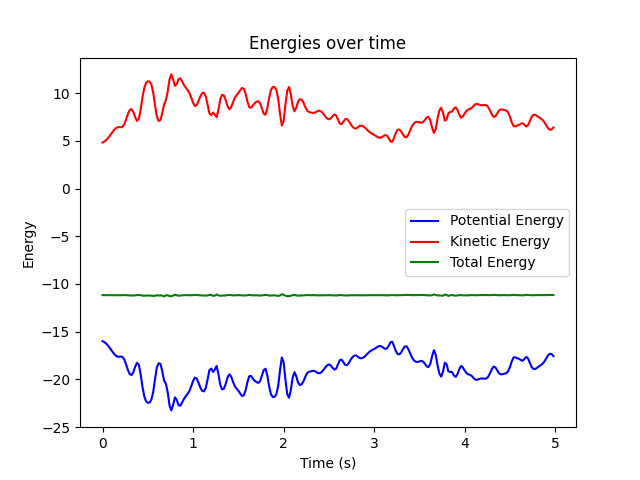

In [2]:
dt = 0.02
tmax = 5

LJ = LJParticles(initialKE = .3, Lx = 6, Ly = 6, nx=4, ny=4, 
                 dt=dt, tmax=tmax, dispEvery=1, cool=False)

PEs, KEs = LJ.saveAnimation("LJpresentation")
TEs = [PEs[i] + KEs[i] for i in range(len(PEs))]

tvar = np.arange(0,tmax,dt)
fig, ax = plt.subplots()

ax.set_xlabel("Time (s)")
ax.set_ylabel("Energy")
ax.set_title("Energies over time")

ax.plot(tvar, PEs, "b", label="Potential Energy")
ax.plot(tvar, KEs, "r", label="Kinetic Energy")
ax.plot(tvar, TEs, "g", label="Total Energy");

ax.legend();

Let's open the gif!

<img src="LJpresentation.gif" style="width:600px"/>

We ran simulations up to 625 particles, but those gifs aren't very pretty because we ran it efficiently, rarely saving the frames to animation. We have a working Lennard-Jones particle simulator! Stay tuned to see another pretty gif!

### Cool, now what do we do with it? cool.

To cool the system, we wrote a simple function called cools(). It:
- Scales each particle's x and y velocities by 90 percent (using default cool_factor=0.9)
- Is called in our advance() function, which updates each particle's position, velocity, and acceleration at every time step

The time delays between coolings can be adjusted with the cool_every argument.

In [ ]:
def cools(self):
    """
    Cools the system by reducing its kinetic energy.
    """
    for i in range(self.N):            # for each particle,
        self.vx[i] *= self.cool_factor # scale its x velocity
        self.vy[i] *= self.cool_factor # and scale its y velocity

## Cool Experiments!

Time for a big experiment! This runs in about 10 minutes, on Conor's very slow computer. Good thing we have that progress bar!

This experiment has 225 particles.

<img src="bigCoolingExpt3.gif" style="width:600px"/>

Notice: We're cooling the system, causing substantial visual changes to its structure

<img src="bigCoolingExpt3.png" style="width:600px"/>

<img src="bigCool8.png" style="width:400px"/> <img src="bigCool39.png" style="width:400px"/>


## Conclusion

In our simulation, we:
- Implemented the Lennard-Jones potential
- Created a molecular dynamics simulation that conserves energy reasonably well
- "Cooled" our system to model a gas-to-liquid or liquid-to-solid phase transition
- Made a neat progress bar!

Future work could involve:
- Adding gravity to a gas-to-liquid phase change
- Calculating the pressure on the walls of the box
- Implementing periodic boundary conditions

### References

1. Amdahl, Kirsten. “Fundamentals of Phase Transitions.” Chemistry LibreTexts, Libretexts, 30 Jan. 2023, https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Physical_Properties_of_Matter/States_of_Matter/Phase_Transitions/Fundamentals_of_Phase_Transitions#:~:text=Phase%20transition%20is%20when%20a,combination%20of%20temperature%20and%20pressure. 

2. Daub, G. William, and William S. Seese. Basic Chemistry. Prentice Hall, 1996. 

3. Graham, Kate. “7.4: London Attractions.” Chemistry LibreTexts, Libretexts, 14 July 2020, https://chem.libretexts.org/Ancillary_Materials/Worksheets/Worksheets%3A_Inorganic_Chemistry/Structure_and_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry/07%3A_Intermolecular_Attraction_and_Structure-Property_Relationships/7.04%3A_London_Attractions. 

4. Naeem, Rabia. “Lennard-Jones Potential.” Chemistry LibreTexts, Libretexts, 15 Apr. 2023, https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Physical_Properties_of_Matter/Atomic_and_Molecular_Properties/Intermolecular_Forces/Specific_Interactions/Lennard-Jones_Potential. 

5. Gould, Harvey, et al. “Many Particle Systems.” An Introduction to Computer Simulation Methods: Applications to Physical Systems, ComPADRE, 2017. 